y_obs [[ 0.45 -0.09  1.88  0.88  0.13 -2.04 -2.21 -3.01 -0.34 -0.33 -0.35 -0.06
  -0.64  1.14 -0.1  -0.86 -1.19 -0.83 -1.69 -0.67 -1.57 -0.54 -0.54  0.33
   1.   -0.35  1.06  0.63 -0.55 -1.35 -0.89  1.1   0.55 -0.95 -1.06 -1.68
  -0.08 -0.8  -0.85  0.42  0.57  0.72  0.65 -0.7  -1.11  0.17  1.51  1.28
   2.05 -1.04  0.16 -1.37  0.75  2.23  0.63 -0.43 -1.43 -1.32 -0.56  0.4
   2.62  0.72 -0.48 -0.36 -1.48  0.07  0.35 -1.26 -0.65 -0.34  0.05 -0.3
  -1.09 -0.03  1.19  0.88 -1.12 -0.41  0.33  0.22 -1.77 -1.44 -1.31 -2.16
  -0.77  0.4  -0.58 -0.97 -2.57 -1.73 -1.55 -1.1  -0.33  0.35  0.53 -0.97
  -1.4  -0.45 -1.13 -1.03]]
Method: Rejection
Number of samples: 1000
Number of simulations: 100000
Threshold: 0.117
Sample means: _prior_0118: -0.0186, _prior_01b8: 0.0253, _prior_3d89: 0.219, _prior_4f29: 0.338, _prior_52c0: 0.332, _prior_7b6a: 0.00266, _prior_b02b: 0.0293, _prior_cb55: 0.556, _prior_d089: 0.335, _prior_ec48: 0.319, t1: 0.00874, t2: 0.333


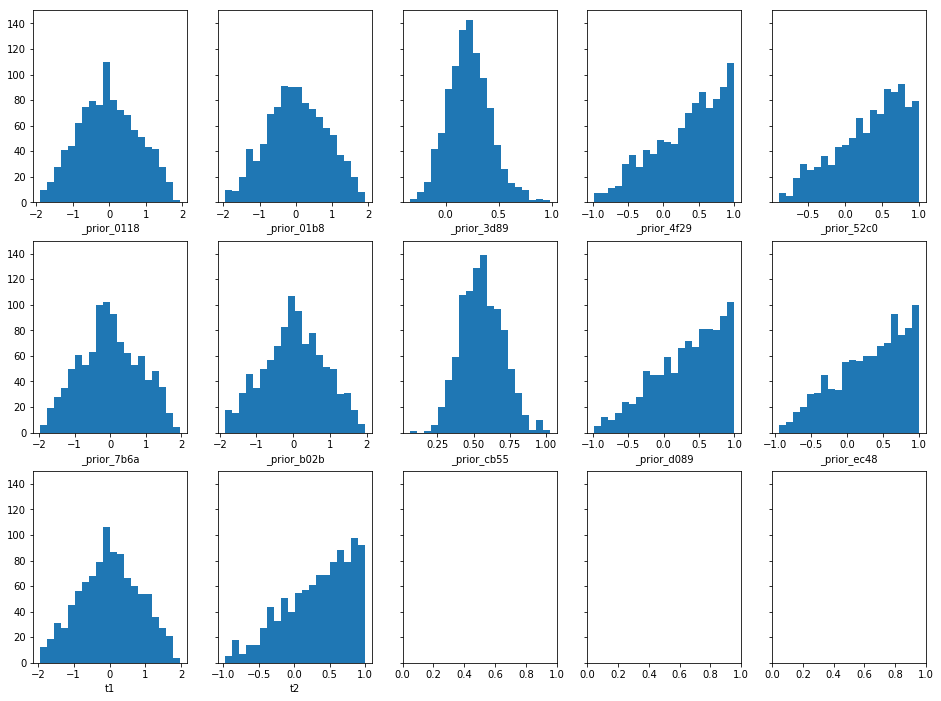

In [6]:
import time

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)  # sometimes this is required to enable logging inside Jupyter
import elfi
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

%matplotlib inline
%precision 2

# Set an arbitrary seed and a global random state to keep the randomly generated quantities the same between runs
seed = 20170530
np.random.seed(seed)

def MA2(t1, t2, n_obs=100, batch_size=1, random_state=None):
    # Make inputs 2d arrays for numpy broadcasting with w
    t1 = np.asanyarray(t1).reshape((-1, 1))
    t2 = np.asanyarray(t2).reshape((-1, 1))
    random_state = random_state or np.random

    w = random_state.randn(batch_size, n_obs+2)  # i.i.d. sequence ~ N(0,1)
    x = w[:, 2:] + t1*w[:, 1:-1] + t2*w[:, :-2]
    return x

# true parameters
t1_true = 0.6
t2_true = 0.2

y_obs = MA2(t1_true, t2_true)
print('y_obs', y_obs)
# a node is defined by giving a distribution from scipy.stats together with any arguments (here 0 and 2)
t1 = elfi.Prior(scipy.stats.uniform, 0, 2)

# ELFI also supports giving the scipy.stats distributions as strings
t2 = elfi.Prior('uniform', 0, 2)

Y = elfi.Simulator(MA2, t1, t2, observed=y_obs)

def autocov(x, lag=1):
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1)
    return C

S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov, Y, 2)  # the optional keyword lag is given the value 2

# Finish the model with the final node that calculates the squared distance (S1_sim-S1_obs)**2 + (S2_sim-S2_obs)**2
d = elfi.Distance('euclidean', S1, S2)

# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class CustomPrior_t1(elfi.Distribution):
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1

# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class CustomPrior_t2(elfi.Distribution):
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return t2
    
t1.become(elfi.Prior(CustomPrior_t1, 2))
t2.become(elfi.Prior(CustomPrior_t2, t1, 1))

elfi.draw(d)

rej = elfi.Rejection(d, batch_size=10000, seed=seed)

N = 1000
result = rej.sample(N)

result.summary()

result.plot_marginals();